Running for n_qubits = 2
Training with 6 samples for n_qubits = 2
Training with 8 samples for n_qubits = 2
Training with 10 samples for n_qubits = 2
Training with 12 samples for n_qubits = 2
Training with 14 samples for n_qubits = 2
Training with 16 samples for n_qubits = 2


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=2.69468e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Training with 18 samples for n_qubits = 2


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Training with 20 samples for n_qubits = 2


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Training with 22 samples for n_qubits = 2


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Training with 24 samples for n_qubits = 2


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Training with 26 samples for n_qubits = 2


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Running for n_qubits = 3
Training with 4 samples for n_qubits = 3
Training with 24 samples for n_qubits = 3
Training with 44 samples for n_qubits = 3
Training with 64 samples for n_qubits = 3


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Training with 84 samples for n_qubits = 3


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Training with 104 samples for n_qubits = 3


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Training with 124 samples for n_qubits = 3


c:\Users\deols\anaconda3\envs\codecraft\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


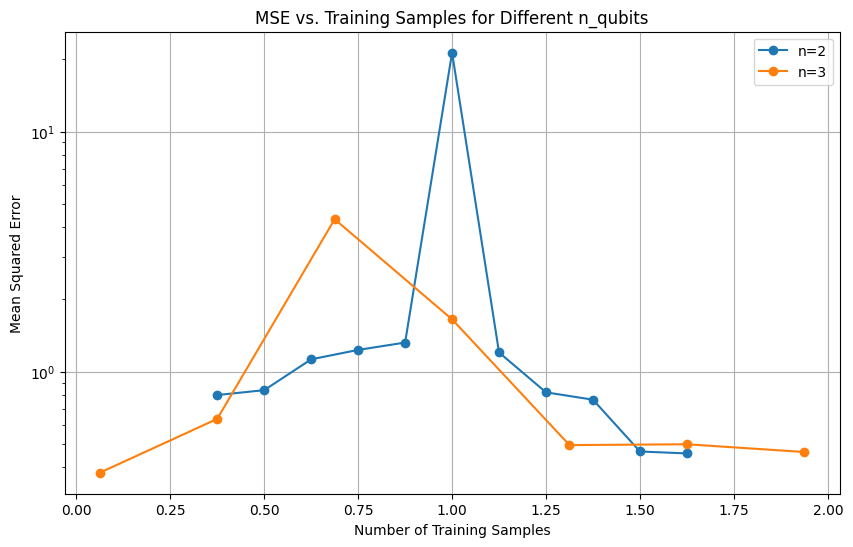

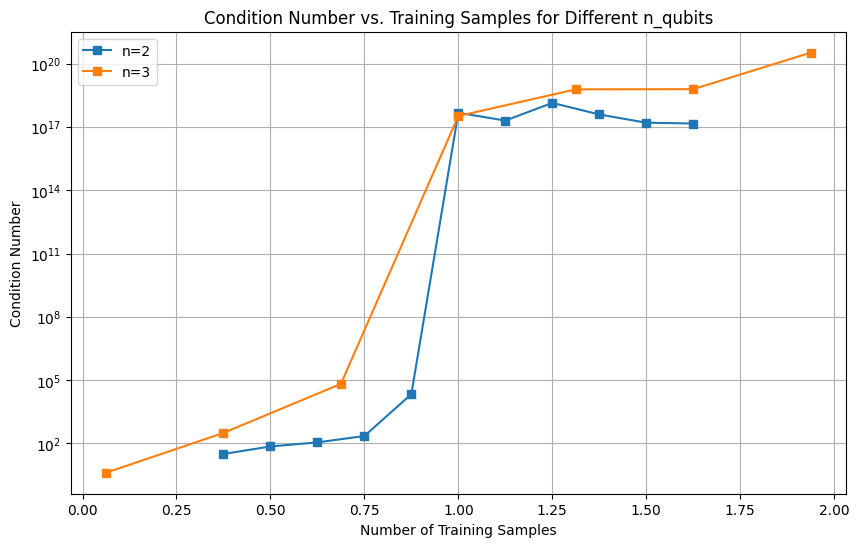

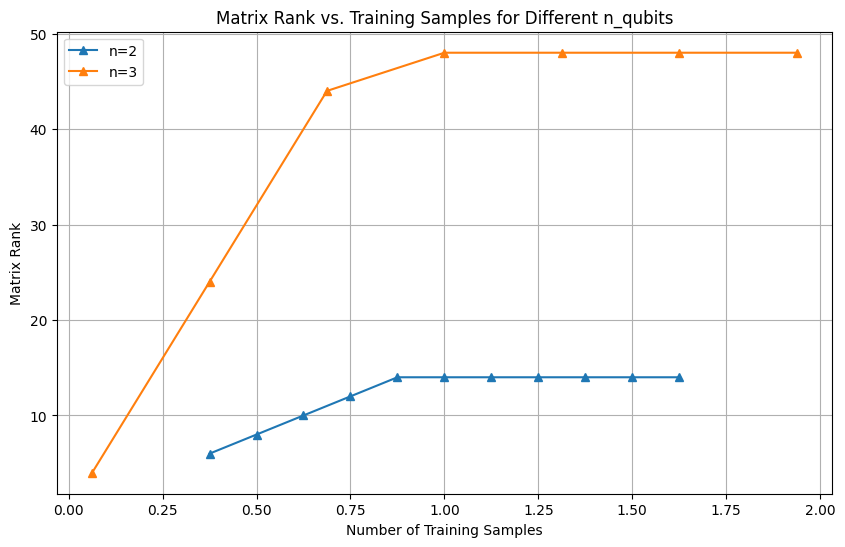

In [3]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import scipy.linalg
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Load Fashion-MNIST dataset
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)
X = X / 255.0  # Normalize

n_qubit_list = [2, 3]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select only classes '0' and '1'
train_filter = np.where((y_train == '0') | (y_train == '1'))
test_filter = np.where((y_test == '0') | (y_test == '1'))
x_train_red, y_train_red = X_train[train_filter], y_train[train_filter]
x_test_red, y_test_red = X_test[test_filter], y_test[test_filter]

# One-hot encode labels
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train_red.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test_red.reshape(-1, 1)).toarray()

# Define function to run quantum kernel learning for different n_qubits
results = {}

for n_qubits in n_qubit_list:
    print(f"Running for n_qubits = {n_qubits}")

    # Perform PCA
    to_use = 2 * n_qubits
    pca = PCA(n_components=to_use)
    x_train = pca.fit_transform(x_train_red)
    x_test = pca.transform(x_test_red)
    
    n_test = 100
    x_test = x_test[:n_test]
    y_test = y_test[:n_test]

    # Quantum feature map
    def quantum_feature_map(x):
        for i in range(len(x)):
            qml.RX(x[i], wires=i % n_qubits)
        for n in range(n_qubits - 1):
            qml.CNOT(wires=[n, n + 1])
        for i in range(len(x)):
            qml.RZ(x[i], wires=i % n_qubits)

    dev_kernel = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        quantum_feature_map(x1)
        qml.adjoint(quantum_feature_map)(x2)
        return qml.expval(qml.Hermitian(np.diag([1] + [0] * (2 ** n_qubits - 1)), wires=range(n_qubits)))

    def kernel_matrix(A, B):
        return np.array([[kernel(a, b) for b in B] for a in A])

    # Define training size limits
    if n_qubits == 2:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 10, 2**(2 * n_qubits) + 11, 2
    elif n_qubits == 3:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 60, 2**(2 * n_qubits) + 61, 20
    elif n_qubits == 4:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 180, 2**(2 * n_qubits) + 181, 60
    elif n_qubits == 5:
        limit_low, limit_up, step = 2**(2 * n_qubits) - 720, 2**(2 * n_qubits) + 721, 240

    mse_list, cond_no_list, rank_list = [], [], []

    for n_train in range(limit_low, limit_up, step):
        x_train_krr = x_train[:n_train]
        y_train_krr = y_train[:n_train]

        print(f"Training with {n_train} samples for n_qubits = {n_qubits}")

        K_train = kernel_matrix(x_train_krr, x_train_krr).astype(np.float64)
        K_test = kernel_matrix(x_test, x_train_krr).astype(np.float64)

        # Train Kernel Ridge Regression
        krr = KernelRidge(kernel='precomputed', alpha=0.0)
        krr.fit(K_train, y_train_krr)

        # Predictions
        y_pred = krr.predict(K_test)
        mse = mean_squared_error(np.real(y_test), y_pred)
        mse_list.append(mse)

        # Compute condition number and rank
        cond_no = np.linalg.cond(K_train)
        rank = np.linalg.matrix_rank(K_train)
        cond_no_list.append(cond_no)
        rank_list.append(rank)

    # Store results
    results[n_qubits] = {
        "mse": mse_list,
        "cond_no": cond_no_list,
        "rank": rank_list,
        "train_sizes": np.arange(limit_low, limit_up, step)/4**n_qubits,
    }

# Plot Results
plt.figure(figsize=(10, 6))

for n_qubits in n_qubit_list:
    plt.plot(
        results[n_qubits]["train_sizes"],
        results[n_qubits]["mse"],
        label=f"n={n_qubits}",
        marker="o",
    )

plt.xlabel("Number of Training Samples")
plt.ylabel("Mean Squared Error")
plt.yscale("log")
plt.title("MSE vs. Training Samples for Different n_qubits")
plt.legend()
plt.grid()
plt.savefig("MSE_vs_TrainingSamples.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))

for n_qubits in n_qubit_list:
    plt.plot(
        results[n_qubits]["train_sizes"],
        results[n_qubits]["cond_no"],
        label=f"n={n_qubits}",
        marker="s",
    )

plt.xlabel("Number of Training Samples")
plt.ylabel("Condition Number")
plt.yscale("log")
plt.title("Condition Number vs. Training Samples for Different n_qubits")
plt.legend()
plt.grid()
plt.savefig("ConditionNumber_vs_TrainingSamples.png", dpi=300)
plt.show()




plt.figure(figsize=(10, 6))

for n_qubits in n_qubit_list:
    plt.plot(
        results[n_qubits]["train_sizes"],
        results[n_qubits]["rank"],
        label=f"n={n_qubits}",
        marker="^",
    )

plt.xlabel("Number of Training Samples")
plt.ylabel("Matrix Rank")
plt.title("Matrix Rank vs. Training Samples for Different n_qubits")
plt.legend()
plt.grid()
plt.savefig("MatrixRank_vs_TrainingSamples.png", dpi=300)
plt.show()
